*This notebook was created by Svitozar Serkez. Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). August 2019.*

## Tutorial N14: SASE estimation and imitation (unfinished)

In [1]:
%matplotlib inline 
import numpy as np
import logging

import ocelot
from ocelot import *
from ocelot.cpbd.beam import *
from ocelot.rad.fel_estimator import *
from ocelot.gui.beam_plot import *
from ocelot.gui.dfl_plot import *

#ocelog.setLevel(logging.ERROR)
#ocelog.setLevel(logging.DEBUG)
ocelog.setLevel(logging.INFO)
plt.clf()
#%matplotlib notebook

initializing ocelot...


## Contents
1. [SASE estimator](#estimator)
2. [SASE imitator](#imitator)

<a id='estimatir'></a>
## SASE estimator
Knowing the electron beam parameters and the magnetic lattice one can estimate the average SASE power at saturation
As the electron beam is typically much longer than the cooperation length, one can slice it into regions that would never interact with each other and estimate power growth in each of those regions with MXie (default) [M. Xie, “Exact and variational solutions of 3D eigenmodes in high gain FELs,” Nucl. Instruments Methods Phys. Res. Sect. A Accel. Spectrometers, Detect. Assoc. Equip., vol. 445, no. 1–3, pp. 59–66, 2000](https://dx.doi.org/10.1016/S0168-9002(00)00114-5) or SSY (assumes optimum beta in each slice) [E. L. Saldin, E. A. Schneidmiller, and M. V. Yurkov, “Design formulas for short-wavelength FELs,” Opt. Commun., vol. 235, no. 4–6, pp. 415–420, May 2004](https://dx.doi.org/10.1016/j.optcom.2004.02.071) estimations

First, let us generate the beam and lattice objects

[INFO    ] generating electron beam distribution
[INFO    ] : plotting beam


<Figure size 640x480 with 0 Axes>

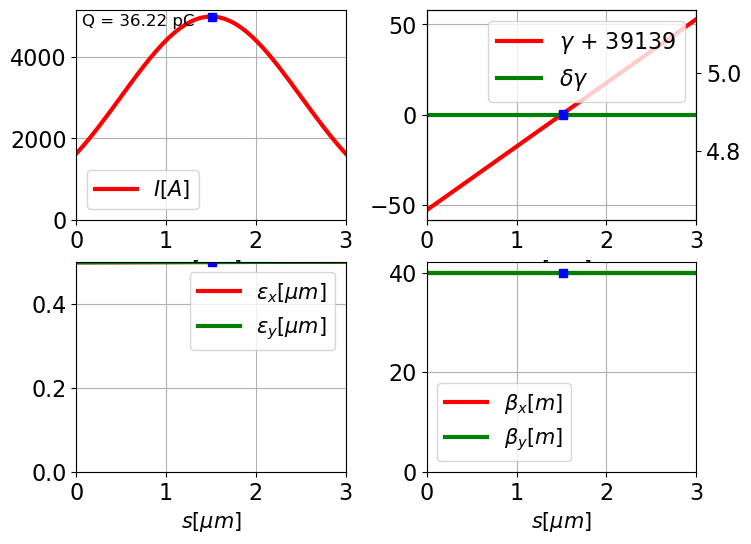

In [2]:
beam = generate_beam(E=14.0, dE=4e-3, I=5000, l_beam=10e-6, emit_n=0.8e-6, beta=40, l_window=30e-6, shape='gaussian', chirp=0.0009)
plot_beam(beam, figsize=2)

In [3]:
#lat_pkg = create_fel_beamline('EuXFEL_SASE1')
lat_pkg = create_fel_lattice(
                    und_N = 35,
                    und_L = 5,
                    und_l = 0.04,
                    und_Kx = 0,
                    und_Ky = 0,
                    inters_L = 1.08,
                    inters_K = 'K_und',
                    inters_phi=0,
                    quad_L = 0.4,
                    quad_K = 0,
                    phs_L = 0.0,
                    quad_start = 'd')

E_photon=8000
beta_av=20
prepare_el_optics(beam, lat_pkg, E_photon, beta_av, s=None)
lat = lat_pkg[0]

#tws0 = Twiss(beam.pk())
#tws = twiss(lat, tws0=tws0)
#plot_opt_func(lat, tws, top_plot=["E"], legend=False)
#plt.show()

There are several ways to estimate SASE power growth

In [4]:
#fel = beam2fel(beam, lu=0.04, K_peak=3, iwityp=0)
fel = beamlat2fel(beam, lat, smear_m=None, method='mxie', qf=0) #slower, propagates the beam through the magnettic lattice to estimate average beta of poorly matched slices
#fel = parraylat2fel(parray, lat, step=1e-7) # would convert parray to beam and execute beamlat2fel
print('zsat = {:.2f}'.format(fel.z_sat_min))
print('E_pulse_sat = {:.2f} uJ'.format(fel.E() * 1e6))

[INFO    ] estimating fel from beam and lat


zsat = 79.91
E_pulse_sat = 1145.08 uJ


Results can be plotted using the following functions

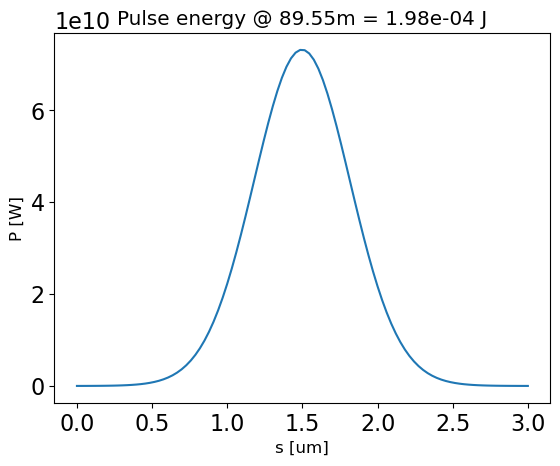

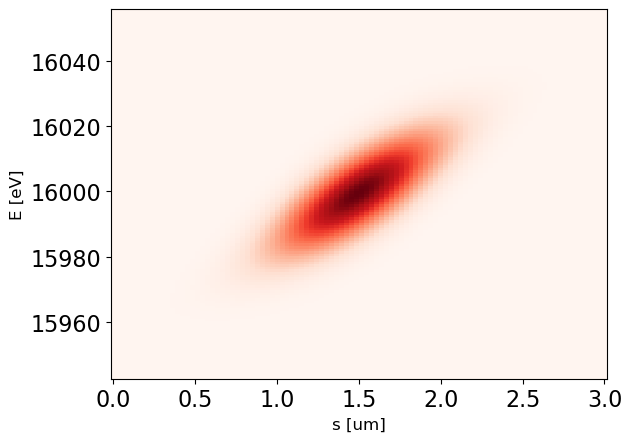

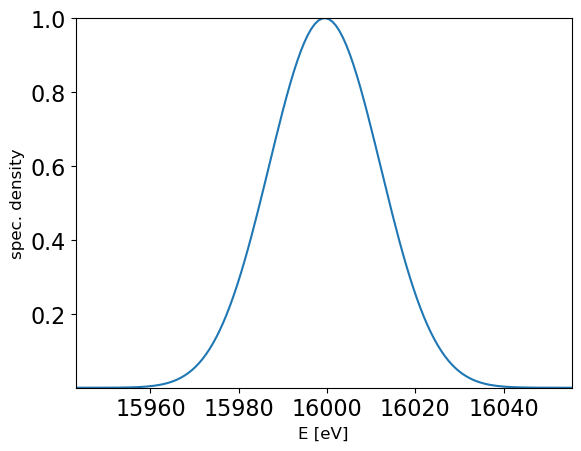

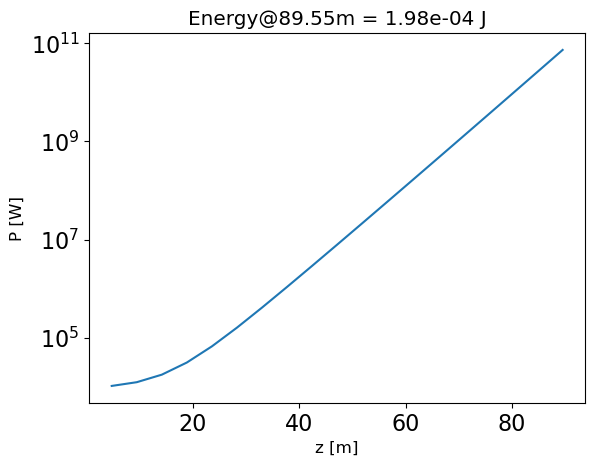

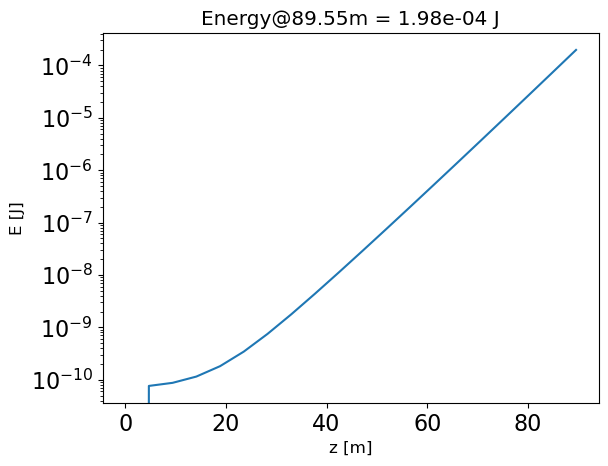

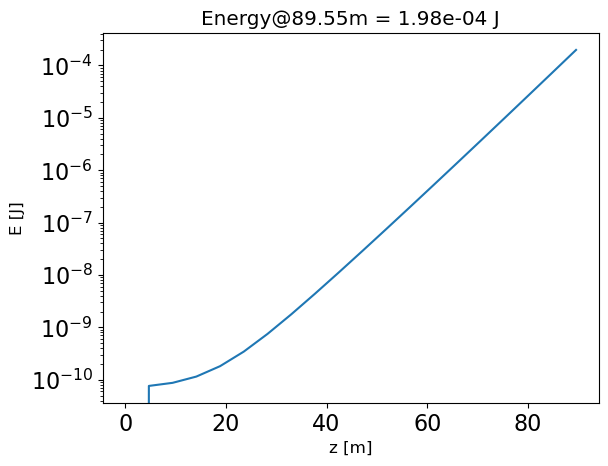

In [5]:
#fel.log('print')
plot_estimator_power_z(fel, und_duty_factor=5/6.08)
plot_estimator_spectrogram(fel)
plot_estimator_spectrum(fel)
plot_estimator_power_evo(fel, und_duty_factor=5/6.08)
plot_estimator_energy_evo(fel, und_duty_factor=5/6.08)

In [9]:
np.trapz(fel.P_sn, fel.s / speed_of_light)

1.8487131823039674e-10

<a id='imitator'></a>
## SASE imitator

One can imitate SASE by simulating Gaussian noise and multiplying it by power profile and spectrum profile envelopes in the time and frequency domains respectively, see [T. Pfeifer et al. “Partial-coherence method to model experimental free-electron laser pulse statistics”. In: Opt. Lett. 35.20 (2010), p. 3441](https://doi.org/10.1364/OL.35.003441)
The `imitate_sase_dfl` function will yield `RadiationField` object, based on `generate_gaussian_dfl`, except longitudinally both the amplitudes and phases are modified to yield SASE like spectrum and power

In [7]:
help(imitate_sase_dfl)

E_pohoton = 16000 #central photon energy [eV]
kwargs={'xlamds':(h_eV_s * speed_of_light / E_pohoton), #[m] - central wavelength
        'shape':(101,101,300),           #(x,y,z) shape of field matrix (reversed) to dfl.fld
        'dgrid':(200e-6,200e-6,15e-6), #(x,y,z) [m] - size of field matrix
        'power_rms':(3e-6,10e-6,2e-6),#(x,y,z) [m] - rms size of the radiation distribution (gaussian)
        'power_center':(0,0,None),     #(x,y,z) [m] - position of the radiation distribution
        'power_angle':(0,0),           #(x,y) [rad] - angle of further radiation propagation
        'power_waistpos':(-5,-15),     #(Z_x,Z_y) [m] downstrean location of the waist of the beam
        'wavelength':None,             #central frequency of the radiation, if different from xlamds
        'zsep':None,                   #distance between slices in z as zsep*xlamds
        'freq_chirp':0,                #dw/dt=[1/fs**2] - requency chirp of the beam around power_center[2]
        #'en_pulse':1e-6,               #total energy or max power of the pulse, use only one
        'power':1e8,
        'rho':1e-4
        }
dfl = imitate_sase_dfl(**kwargs);

[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape (nz,ny,nx): (101, 101, 300)


Help on function imitate_sase_dfl in module ocelot.optics.wave:

imitate_sase_dfl(xlamds, rho=0.0002, seed=None, **kwargs)
    imitation of SASE radiation in 3D
    
    xlamds - wavelength of the substracted fast-varying component
    rho - half of the expected FEL bandwidth
    **kwargs identical to generate_dfl()
    
    returns RadiationField object



[INFO    ] : generating 1d radiation field imitating SASE


[INFO    ] plotting radiation field (dfl)


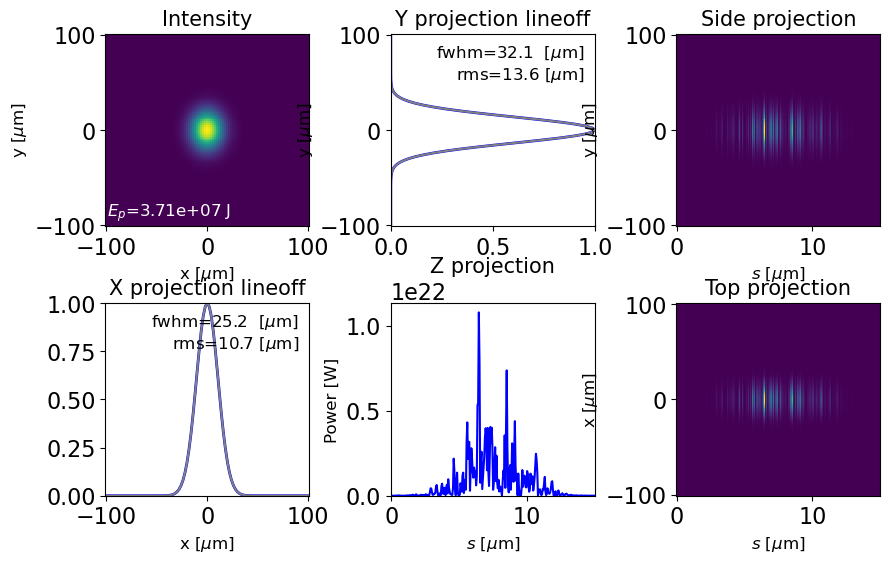

[INFO    ] plotting radiation field (dfl)


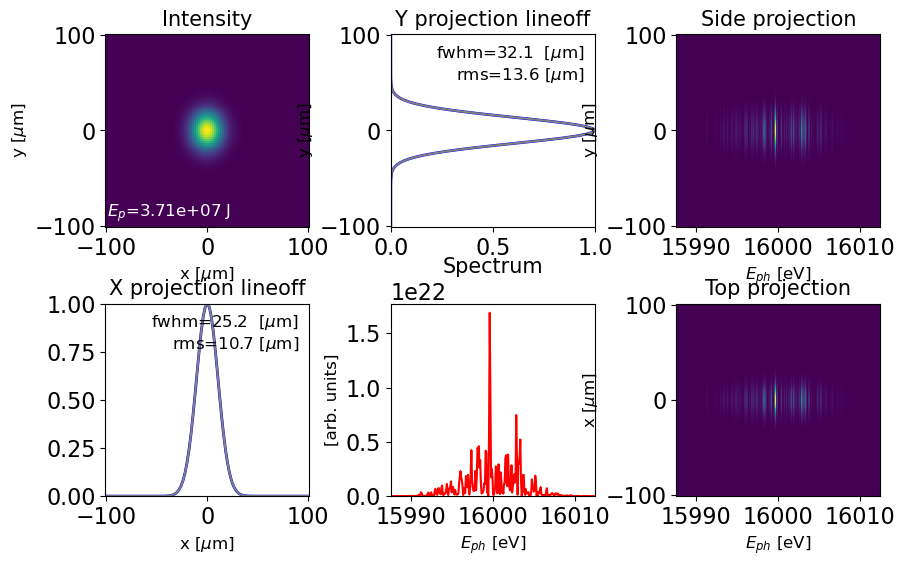

In [8]:
plot_dfl(dfl, domains = 'st', figsize=2)
plot_dfl(dfl, domains = 'sf', figsize=2)